In [1]:
import re
import sys
from time import time, sleep
from pprint import pprint
from functools import partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt

FILENAME = "main.cpp"

In [2]:
!cp ../answer/main.cpp ./{FILENAME}

In [3]:
#!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME}.out
!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -o {FILENAME}.out

main.cpp:49: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
   49 | #pragma clang attribute push (__attribute__((target("arch=skylake"))),apply_to=function)
      | 
main.cpp:1377: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
 1377 | #pragma clang attribute pop
      | 
main.cpp: In function ‘void globals::UpdateValueTable()’:
main.cpp:821:15: warning: unused variable ‘vm’ [-Wunused-variable]
  821 |   const auto& vm = v_modified[idx_RCSEV];
      |               ^~
main.cpp: In function ‘void Solve()’:
main.cpp:1281:72: warning: missing initializer for member ‘Solve()::Node::action’ [-Wmissing-field-initializers]
 1281 |   node_buffer.push({ state_buffer[0].score, nullptr, &state_buffer[0] });
      |                                                                        ^
main.cpp: In instantiation of ‘HashMap<T, size, KeyType>::HashMap() [with T = double; int size = 1048576; KeyType = long long unsigned int]’:
main.cpp:535:26:   required from here
mai

In [4]:
# テストケース生成
SEED = 1000
N_TESTCASES = 200

!mkdir in
for i in range(N_TESTCASES):
    filename = f"{i:04d}.txt"
    seed = SEED + i
    !python3 ../A/tester/generator.py {seed} > ./in/{filename}
!ls in

0000.txt  0025.txt  0050.txt  0075.txt	0100.txt  0125.txt  0150.txt  0175.txt
0001.txt  0026.txt  0051.txt  0076.txt	0101.txt  0126.txt  0151.txt  0176.txt
0002.txt  0027.txt  0052.txt  0077.txt	0102.txt  0127.txt  0152.txt  0177.txt
0003.txt  0028.txt  0053.txt  0078.txt	0103.txt  0128.txt  0153.txt  0178.txt
0004.txt  0029.txt  0054.txt  0079.txt	0104.txt  0129.txt  0154.txt  0179.txt
0005.txt  0030.txt  0055.txt  0080.txt	0105.txt  0130.txt  0155.txt  0180.txt
0006.txt  0031.txt  0056.txt  0081.txt	0106.txt  0131.txt  0156.txt  0181.txt
0007.txt  0032.txt  0057.txt  0082.txt	0107.txt  0132.txt  0157.txt  0182.txt
0008.txt  0033.txt  0058.txt  0083.txt	0108.txt  0133.txt  0158.txt  0183.txt
0009.txt  0034.txt  0059.txt  0084.txt	0109.txt  0134.txt  0159.txt  0184.txt
0010.txt  0035.txt  0060.txt  0085.txt	0110.txt  0135.txt  0160.txt  0185.txt
0011.txt  0036.txt  0061.txt  0086.txt	0111.txt  0136.txt  0161.txt  0186.txt
0012.txt  0037.txt  0062.txt  0087.txt	0112.txt  0137.txt  0162.

In [5]:
TESTCASE_DIRECTORY = "./in/"
TESTCASES = [f"{i:04d}.txt" for i in range(N_TESTCASES)]

In [6]:
# もとのスコアの確認

scores = []
times = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

with Pool(4) as p:
    for score, t in p.map(parallel, range(N_TESTCASES)):
        scores.append(score)
        times.append(t)

np.mean(scores) * 50 / 1e6, np.std(scores) * 50 / 1e6

0013 time:2.4559 score:5178430
0039 time:2.5824 score:5536539
0026 time:2.6042 score:4894464
0000 time:2.6755 score:4903030
0014 time:2.3062 score:5398016
0040 time:2.4042 0027score:4792872 
time:2.4000 score:5657595
0001 time:2.6995 score:5355210
0015 time:2.5627 score:5484287
0041 time:2.3788 score:4530063
0028 time:2.5821 score:5069833
0002 time:2.4664 score:4687592
0016 time:2.5443 score:5079234
0042 time:2.6599 score:5360441
0029 time:2.5025 score:5236158
0003 time:2.3110 score:4687261
0017 time:2.5105 score:4503560
0043 time:2.5853 score:5044637
0004 time:2.5528 score:4595307
0030 time:2.6985 score:4853766
0044 time:2.2201 score:5142329
0018 time:2.5117 score:4995041
0005 time:2.3612 score:5138846
0031 time:2.3471 score:4491734
0019 time:2.3659 score:4579212
0006 time:2.3617 score:4500612
0045 time:2.6186 score:5272829
0032 time:2.3955 score:5450502
0020 time:2.2025 score:4699695
0033 time:2.0821 score:4156374
0007 time:2.3624 score:5324944
0046 time:2.4198 score:5044275
0021 tim

(248.16697825000003, 17.78923519055877)

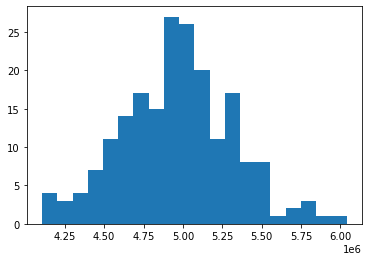

In [7]:
plt.hist(scores, bins=20)
plt.show()

In [8]:
# ここでエラー出力は何かおかしいかもしれない


# パラメータ抽出
with open(FILENAME) as f:
    answer = f.read()


variables_optimize = []

for left, value, right, options in re.findall(r"^([^/\n]*=\s*)(.+?)(\s*;\s*//(?:.*\W)?OPTIMIZE(\W.*))$", answer, re.MULTILINE):
    name = left.replace("=", "").strip().split()[-1]
    
    searched = re.search(r".*\[(?P<min>.*),(?P<max>.*)\].*", options)
    if searched:
        min_value = max_value = None
        try:
            min_value = eval(searched.group("min"))
            max_value = eval(searched.group("max"))
            assert min_value <= max_value
        except Exception as e:
            print(f"searched={searched}", file=sys.stderr)
            print(e, file=sys.stderr)
            continue
        log = "LOG" in options  # 雑、直したほうが良い
        if type(min_value) != type(max_value):
            print(f"searched={searched}", file=sys.stderr)
            print("types not matched", file=sys.stderr)
            continue
        if isinstance(min_value, int):
            method = "suggest_int"
        elif isinstance(min_value, float):
            method = "suggest_float"
        else:
            print(f"searched={searched}", file=sys.stderr)
            print(f"unknown type ({type(min_value)})", file=sys.stderr)
            continue
        variables_optimize.append({
            "name": name,
            "method": method,
            "min": min_value,
            "max": max_value,
            "log": log,
            "left": left,
            "right": right,
        })
    elif searched := re.search(r".*\{(?P<choices>.*?)\}.*", options):
        choices = list(map(lambda x: x.strip(), searched.group("choices").split(",")))
        variables_optimize.append({
            "name": name,
            "method": "suggest_categorical",
            "choices": choices,
            "left": left,
            "right": right,
        })
    else:
        print(f"searched={searched}", file=sys.stderr)
        print(f"pattern was matched but options are incorrect.", file=sys.stderr)

print(len(variables_optimize), "variables were found.")
if globals().get("pd"):
    display(pd.DataFrame(variables_optimize))
else:
    pprint(variables_optimize)

6 variables were found.


,name,method,min,max,log,left,right,choices
0,K_START,suggest_float,0.020,0.060,True,constexpr double K_START =,"; // OPTIMIZE [0.02, 0.06] LOG",NaN
1,K_END,suggest_float,0.010,0.050,True,constexpr double K_END =,"; // OPTIMIZE [0.01, 0.05] LOG",NaN
2,K_H,suggest_float,0.001,0.999,False,constexpr double K_H =,"; // OPTIMIZE [0.001, 0.999]",NaN
3,PURCHASE_TURN_LIMIT,suggest_int,790.000,870.000,False,constexpr short PURCHASE_TURN_LIMIT =,"; // OPTIMIZE [790, 870]",NaN
4,SUBSCORE3_TIGHT_TURN,suggest_int,0.000,2.000,False,constexpr int SUBSCORE3_TIGHT_TURN =,"; // OPTIMIZE [0, 2]",NaN
5,ROUGH_HASH,suggest_categorical,NaN,NaN,NaN,constexpr int ROUGH_HASH =,"; // OPTIMIZE {0, 0b00000001, 0b00010001,...","[0, 0b00000001, 0b00010001, 0b00010011, 0b0011..."


In [9]:
def escape(string):  # 正規表現の中でそのまま使いたい文字列をエスケープ
    res = !echo '{string}' | sed -e 's/[]\/$*.^[]/\\&/g'
    return res[0]

def escape_sed(string):  # sed の置換後の文字列用のエスケープ
    res = !echo '{string}' | sed -e 's/[\/&]/\\&/g'
    return res[0]


def objective_with_index(trial, n_internal_parallel):
    index_parallel = trial.number % 12  # これ変数にする
    print(f"{index_parallel=}")
    
    parameters_changed_filename = f"{index_parallel}_{FILENAME}"
    #directory_input = "./in"  # "/" をつけない  # 中のすべてのファイルに対して実行される
    
    !mkdir {index_parallel}_out 2> /dev/null
    !mkdir {index_parallel}_score 2> /dev/null
    !rm {index_parallel}_out/*
    !rm {index_parallel}_score/*
    
    # ファイル作成
    !cp {FILENAME} {parameters_changed_filename}
    sed_options = [f"-i {parameters_changed_filename}"]
    for variable in variables_optimize:
        if variable["method"] == "suggest_categorical":
            val =  trial.suggest_categorical(variable["name"], variable["choices"])
        else:
            val = getattr(trial, variable["method"])(variable["name"], variable["min"], variable["max"], log=variable["log"])
        left = variable["left"]
        right = variable["right"]
        sed_options.append(f"""-e 's/^{escape(left)}.*{escape(right)}$/{escape_sed(left)}{val}{escape_sed(right)}/'""")
    command_sed = f"sed {' '.join(sed_options)}"
    print(command_sed)
    !{command_sed}
    
    # コンパイル
    command_compile = f"g++ {parameters_changed_filename} -std=gnu++17 -O2 -DONLINE_JUDGE -o {parameters_changed_filename}.out 2> /dev/null"
    print(command_compile)
    !{command_compile}
    
    # 実行・採点コマンド (@ はファイル名)
    command_exec = (
        f"./{parameters_changed_filename}.out < {TESTCASE_DIRECTORY}@ >./{index_parallel}_out/@ 2> /dev/null;"
        f"python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}@ ./{index_parallel}_out/@ > ./{index_parallel}_score/@"
        
        #f"cargo run --release --manifest-path ../tools/Cargo.toml --bin tester {directory_input}/@ $(pwd)/{parameters_changed_filename}.out 2>&1 | grep Score | sed -E s/[^0-9]+// > ./{index_parallel}_score/@;"
        
        #f"./{parameters_changed_filename}.out < {directory_input}/@ > ./{index_parallel}_out/@;"
        #f"cargo run --release --manifest-path ./tools/Cargo.toml --bin vis {directory_input}/@ ./{index_parallel}_out/@ 2> /dev/null > ./{index_parallel}_score/@;"
    )
    
    # 並列実行 (sed はパスのディレクトリ部分を消してファイル名にしてる)
    !find {TESTCASE_DIRECTORY}/* | sed 's!^.*/!!' | xargs -I@ -P {n_internal_parallel} sh -c '{command_exec}'
    
    # 集計
    file_paths = !find ./{index_parallel}_score/*
    sum_score = 0
    for file_path in file_paths:  
        with open(file_path) as f:
            sum_score += int(f.read().split(":")[-1])
    return sum_score

In [ ]:
storage_path = f"study.db"
storage = f"sqlite:///{storage_path}"
study_name = "study"
study = optuna.create_study(storage=storage, load_if_exists=True, study_name=study_name, direction="maximize")

def callback(study, trial):
    try:
        if study.best_value == trial.value:
            print(f"Updated! {study.best_value}")
            index_parallel = trial.number % 12
            parameters_changed_filename = f"{index_parallel}_{FILENAME}"
            !cp {parameters_changed_filename} 00000optimized.cpp
        print("callback ok")
    except:
        print(":(")

objective = partial(objective_with_index, n_internal_parallel=4)
study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=4, callbacks=[callback])

[I 2021-09-10 07:33:26,869] A new study created in RDB with name: study


index_parallel=1
index_parallel=0
index_parallel=2
index_parallel=3


/home/nagis/anaconda3/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


rm: cannot remove '1_out/*': No such file or directory
rm: cannot remove '0_out/*': No such file or directory
rm: cannot remove '2_out/*': No such file or directory
rm: cannot remove '3_out/*': No such file or directory
rm: cannot remove '1_score/*': No such file or directory
rm: cannot remove '0_score/*': No such file or directory
rm: cannot remove '2_score/*': No such file or directory
rm: cannot remove '3_score/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022495936365830794;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.015798434636574876;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2846019186098313;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[79

[I 2021-09-10 07:37:10,312] Trial 0 finished with value: 949063732.0 and parameters: {'K_START': 0.04526394109504011, 'K_END': 0.02691558856702044, 'K_H': 0.4180271131768966, 'PURCHASE_TURN_LIMIT': 846, 'SUBSCORE3_TIGHT_TURN': 2, 'ROUGH_HASH': '0b00110011'}. Best is trial 0 with value: 949063732.0.


Updated! 949063732.0
callback ok
index_parallel=4
rm: cannot remove '4_out/*': No such file or directory
rm: cannot remove '4_score/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02070893357730182;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.027091655539374898;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.35111829900652547;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0

[I 2021-09-10 07:37:22,491] Trial 1 finished with value: 880448023.0 and parameters: {'K_START': 0.022495936365830794, 'K_END': 0.015798434636574876, 'K_H': 0.2846019186098313, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 2, 'ROUGH_HASH': '0b00010011'}. Best is trial 0 with value: 949063732.0.


callback ok
index_parallel=5
rm: cannot remove '5_out/*': No such file or directory
rm: cannot remove '5_score/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.023917783544755794;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0137420507522065;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3622447833216012;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 07:37:40,724] Trial 2 finished with value: 911529242.0 and parameters: {'K_START': 0.02692951895894397, 'K_END': 0.018670265729852836, 'K_H': 0.8529498139269086, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001'}. Best is trial 0 with value: 949063732.0.


callback ok
index_parallel=6
rm: cannot remove '6_out/*': No such file or directory
rm: cannot remove '6_score/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03281919866678202;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.011071283827106676;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.19991982142029366;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 07:38:11,276] Trial 3 finished with value: 924596109.0 and parameters: {'K_START': 0.033866334674947214, 'K_END': 0.016612115677483306, 'K_H': 0.4600196139925108, 'PURCHASE_TURN_LIMIT': 852, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 0 with value: 949063732.0.


callback ok
index_parallel=7
rm: cannot remove '7_out/*': No such file or directory
rm: cannot remove '7_score/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03030814816457211;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0450573984188926;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.28959194752643697;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 859;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 07:41:11,616] Trial 5 finished with value: 853266798.0 and parameters: {'K_START': 0.023917783544755794, 'K_END': 0.0137420507522065, 'K_H': 0.3622447833216012, 'PURCHASE_TURN_LIMIT': 825, 'SUBSCORE3_TIGHT_TURN': 2, 'ROUGH_HASH': '0b00010011'}. Best is trial 0 with value: 949063732.0.


callback ok
index_parallel=8
rm: cannot remove '8_out/*': No such file or directory
rm: cannot remove '8_score/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02132514257214662;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.012700234186480138;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8418585216288428;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 822;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001,

[I 2021-09-10 07:41:42,032] Trial 6 finished with value: 904155510.0 and parameters: {'K_START': 0.03281919866678202, 'K_END': 0.011071283827106676, 'K_H': 0.19991982142029366, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011'}. Best is trial 0 with value: 949063732.0.


callback ok
index_parallel=9
rm: cannot remove '9_out/*': No such file or directory
rm: cannot remove '9_score/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05016721750475958;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.013568287410611408;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4903005342792874;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 800;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001,

[I 2021-09-10 07:41:47,326] Trial 4 finished with value: 948929342.0 and parameters: {'K_START': 0.02070893357730182, 'K_END': 0.027091655539374898, 'K_H': 0.35111829900652547, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0'}. Best is trial 0 with value: 949063732.0.


callback ok
index_parallel=10
rm: cannot remove '10_out/*': No such file or directory
rm: cannot remove '10_score/*': No such file or directory
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.041658517746958994;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.021101684235332475;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9595423542392845;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 791;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b0001

[I 2021-09-10 07:43:03,156] Trial 7 finished with value: 984177095.0 and parameters: {'K_START': 0.03030814816457211, 'K_END': 0.0450573984188926, 'K_H': 0.28959194752643697, 'PURCHASE_TURN_LIMIT': 859, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0'}. Best is trial 7 with value: 984177095.0.


Updated! 984177095.0
callback ok
index_parallel=11
rm: cannot remove '11_out/*': No such file or directory
rm: cannot remove '11_score/*': No such file or directory
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.058074479219457076;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.022220308267472982;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.04858557428607375;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE 

[I 2021-09-10 07:44:41,406] Trial 8 finished with value: 799162425.0 and parameters: {'K_START': 0.02132514257214662, 'K_END': 0.012700234186480138, 'K_H': 0.8418585216288428, 'PURCHASE_TURN_LIMIT': 822, 'SUBSCORE3_TIGHT_TURN': 2, 'ROUGH_HASH': '0b00110011'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02733367466571329;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.012690374160873149;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5877813168220086;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 07:45:30,673] Trial 9 finished with value: 872336214.0 and parameters: {'K_START': 0.05016721750475958, 'K_END': 0.013568287410611408, 'K_H': 0.4903005342792874, 'PURCHASE_TURN_LIMIT': 800, 'SUBSCORE3_TIGHT_TURN': 2, 'ROUGH_HASH': '0b00010011'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04180189202123433;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04785855235489811;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.0055895435334670784;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 869;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 07:45:32,227] Trial 10 finished with value: 877747002.0 and parameters: {'K_START': 0.041658517746958994, 'K_END': 0.021101684235332475, 'K_H': 0.9595423542392845, 'PURCHASE_TURN_LIMIT': 791, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.059828271330966194;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049488418714021556;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.09762200504988733;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 869;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 07:47:10,901] Trial 11 finished with value: 982341651.0 and parameters: {'K_START': 0.058074479219457076, 'K_END': 0.022220308267472982, 'K_H': 0.04858557428607375, 'PURCHASE_TURN_LIMIT': 848, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010011'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05867287357455461;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04419381710641848;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.026116342782326406;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 870;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001,

[I 2021-09-10 07:48:32,900] Trial 12 finished with value: 859262661.0 and parameters: {'K_START': 0.02733367466571329, 'K_END': 0.012690374160873149, 'K_H': 0.5877813168220086, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05844808619535189;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047337138683633116;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.005397980962623214;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 870;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 07:50:12,226] Trial 14 finished with value: 976478072.0 and parameters: {'K_START': 0.059828271330966194, 'K_END': 0.049488418714021556, 'K_H': 0.09762200504988733, 'PURCHASE_TURN_LIMIT': 869, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00000001'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04013391606523093;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03563603690962389;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.0202894322667204;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 862;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 07:50:13,941] Trial 13 finished with value: 973890994.0 and parameters: {'K_START': 0.04180189202123433, 'K_END': 0.04785855235489811, 'K_H': 0.0055895435334670784, 'PURCHASE_TURN_LIMIT': 869, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00000001'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0296997719468645;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03615021930937072;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.1464769209615175;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 859;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 07:51:51,760] Trial 15 finished with value: 974658651.0 and parameters: {'K_START': 0.05867287357455461, 'K_END': 0.04419381710641848, 'K_H': 0.026116342782326406, 'PURCHASE_TURN_LIMIT': 870, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00000001'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03222023260514894;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03497378593935894;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.16015887163439096;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 858;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 07:53:12,270] Trial 16 finished with value: 976408191.0 and parameters: {'K_START': 0.05844808619535189, 'K_END': 0.047337138683633116, 'K_H': 0.005397980962623214, 'PURCHASE_TURN_LIMIT': 870, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00000001'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.029727077473909225;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03474214784514745;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.1819862031781785;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 859;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 07:55:01,149] Trial 18 finished with value: 972713650.0 and parameters: {'K_START': 0.0296997719468645, 'K_END': 0.03615021930937072, 'K_H': 0.1464769209615175, 'PURCHASE_TURN_LIMIT': 859, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.038658084704726974;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03152896667682744;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2502638935794552;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 859;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 07:55:02,661] Trial 17 finished with value: 979815827.0 and parameters: {'K_START': 0.04013391606523093, 'K_END': 0.03563603690962389, 'K_H': 0.0202894322667204, 'PURCHASE_TURN_LIMIT': 862, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.037640184642594096;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.026051365591373724;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.26982506639688875;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 815;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b000100

[I 2021-09-10 07:56:39,234] Trial 19 finished with value: 978206096.0 and parameters: {'K_START': 0.03222023260514894, 'K_END': 0.03497378593935894, 'K_H': 0.16015887163439096, 'PURCHASE_TURN_LIMIT': 858, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04950436407319281;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.026128167973095015;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5948173561943918;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 07:58:00,382] Trial 20 finished with value: 971811689.0 and parameters: {'K_START': 0.029727077473909225, 'K_END': 0.03474214784514745, 'K_H': 0.1819862031781785, 'PURCHASE_TURN_LIMIT': 859, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03761092761678018;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.027041334659886906;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6226049512576731;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 854;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 07:59:13,411] Trial 22 finished with value: 958052687.0 and parameters: {'K_START': 0.037640184642594096, 'K_END': 0.026051365591373724, 'K_H': 0.26982506639688875, 'PURCHASE_TURN_LIMIT': 815, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010001'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05017599821554826;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.037583583567932316;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.635471284096013;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 07:59:23,132] Trial 21 finished with value: 971381691.0 and parameters: {'K_START': 0.038658084704726974, 'K_END': 0.03152896667682744, 'K_H': 0.2502638935794552, 'PURCHASE_TURN_LIMIT': 859, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010001'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.049164756673025445;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04057718748121006;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.0949652122519512;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 852;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 08:00:51,037] Trial 23 finished with value: 963342663.0 and parameters: {'K_START': 0.04950436407319281, 'K_END': 0.026128167973095015, 'K_H': 0.5948173561943918, 'PURCHASE_TURN_LIMIT': 830, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010001'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05157898243644002;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.039779328772963446;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.10280099774944629;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 851;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 08:02:20,989] Trial 24 finished with value: 958517058.0 and parameters: {'K_START': 0.03761092761678018, 'K_END': 0.027041334659886906, 'K_H': 0.6226049512576731, 'PURCHASE_TURN_LIMIT': 854, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0b00010001'}. Best is trial 7 with value: 984177095.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0528540435162518;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04068915506093383;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.09260635998002045;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 08:03:51,892] Trial 25 finished with value: 992673639.0 and parameters: {'K_START': 0.05017599821554826, 'K_END': 0.037583583567932316, 'K_H': 0.635471284096013, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0'}. Best is trial 25 with value: 992673639.0.


Updated! 992673639.0
callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05252912606645907;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.039800064459256886;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7069859358502452;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 

[I 2021-09-10 08:04:12,878] Trial 26 finished with value: 995780238.0 and parameters: {'K_START': 0.049164756673025445, 'K_END': 0.04057718748121006, 'K_H': 0.0949652122519512, 'PURCHASE_TURN_LIMIT': 852, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0'}. Best is trial 26 with value: 995780238.0.


Updated! 995780238.0
callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05117765872505775;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04126959754483319;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6859966732675891;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0

[I 2021-09-10 08:05:36,822] Trial 27 finished with value: 994955896.0 and parameters: {'K_START': 0.05157898243644002, 'K_END': 0.039779328772963446, 'K_H': 0.10280099774944629, 'PURCHASE_TURN_LIMIT': 851, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0'}. Best is trial 26 with value: 995780238.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.051057975886682566;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04001165562696463;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7017425429891802;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 08:07:01,141] Trial 28 finished with value: 998751721.0 and parameters: {'K_START': 0.0528540435162518, 'K_END': 0.04068915506093383, 'K_H': 0.09260635998002045, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0'}. Best is trial 28 with value: 998751721.0.


Updated! 998751721.0
callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.046982723008858175;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.041153470959985464;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.09948654633469621;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0

[I 2021-09-10 08:08:34,527] Trial 29 finished with value: 1000208017.0 and parameters: {'K_START': 0.05252912606645907, 'K_END': 0.039800064459256886, 'K_H': 0.7069859358502452, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 29 with value: 1000208017.0.


Updated! 1000208017.0
callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.047060763833275766;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0312157598585046;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7083123368201971;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 813;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b0

[I 2021-09-10 08:08:55,313] Trial 30 finished with value: 987165130.0 and parameters: {'K_START': 0.05117765872505775, 'K_END': 0.04126959754483319, 'K_H': 0.6859966732675891, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 2, 'ROUGH_HASH': '0'}. Best is trial 29 with value: 1000208017.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.045256288654474924;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03125476864164844;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7623936180089513;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 817;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 08:10:21,287] Trial 31 finished with value: 1001169750.0 and parameters: {'K_START': 0.051057975886682566, 'K_END': 0.04001165562696463, 'K_H': 0.7017425429891802, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 31 with value: 1001169750.0.


Updated! 1001169750.0
callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0453627355821433;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.030871333451083047;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7508025248213727;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0

[I 2021-09-10 08:10:41,909] Trial 32 finished with value: 971925290.0 and parameters: {'K_START': 0.046982723008858175, 'K_END': 0.041153470959985464, 'K_H': 0.09948654633469621, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 2, 'ROUGH_HASH': '0b00110011'}. Best is trial 31 with value: 1001169750.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05421343421826103;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0308587808057454;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7703512153870422;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 818;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 08:12:11,478] Trial 33 finished with value: 955387322.0 and parameters: {'K_START': 0.047060763833275766, 'K_END': 0.0312157598585046, 'K_H': 0.7083123368201971, 'PURCHASE_TURN_LIMIT': 813, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011'}. Best is trial 31 with value: 1001169750.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05435874403606726;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03096512496145624;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8001456588399023;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 823;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 08:12:33,325] Trial 34 finished with value: 955479844.0 and parameters: {'K_START': 0.045256288654474924, 'K_END': 0.03125476864164844, 'K_H': 0.7623936180089513, 'PURCHASE_TURN_LIMIT': 817, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011'}. Best is trial 31 with value: 1001169750.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05435543430383069;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.043178909223385166;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5296670000764965;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 08:14:02,777] Trial 35 finished with value: 966535004.0 and parameters: {'K_START': 0.0453627355821433, 'K_END': 0.030871333451083047, 'K_H': 0.7508025248213727, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011'}. Best is trial 31 with value: 1001169750.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.054514534747565103;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.039965519040686064;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5391637706117818;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 08:15:19,287] Trial 36 finished with value: 976597309.0 and parameters: {'K_START': 0.05421343421826103, 'K_END': 0.0308587808057454, 'K_H': 0.7703512153870422, 'PURCHASE_TURN_LIMIT': 818, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 31 with value: 1001169750.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.054520999752665715;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04365079972021234;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5408609387656238;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 08:16:49,488] Trial 37 finished with value: 978696987.0 and parameters: {'K_START': 0.05435874403606726, 'K_END': 0.03096512496145624, 'K_H': 0.8001456588399023, 'PURCHASE_TURN_LIMIT': 823, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 31 with value: 1001169750.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.054043498486915455;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04285421640408206;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.43357394854987946;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 08:17:18,453] Trial 38 finished with value: 1004253489.0 and parameters: {'K_START': 0.05435543430383069, 'K_END': 0.043178909223385166, 'K_H': 0.5296670000764965, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 38 with value: 1004253489.0.


Updated! 1004253489.0
callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05534648435628764;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.044190170956542374;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5535193511120388;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001,

[I 2021-09-10 08:18:43,499] Trial 39 finished with value: 997971666.0 and parameters: {'K_START': 0.054514534747565103, 'K_END': 0.039965519040686064, 'K_H': 0.5391637706117818, 'PURCHASE_TURN_LIMIT': 827, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 38 with value: 1004253489.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04361410211705733;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04468981301322566;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4168676241562307;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 08:19:59,298] Trial 40 finished with value: 1002509202.0 and parameters: {'K_START': 0.054520999752665715, 'K_END': 0.04365079972021234, 'K_H': 0.5408609387656238, 'PURCHASE_TURN_LIMIT': 827, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 38 with value: 1004253489.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05444511742140762;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0438449182376662;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4015564358824474;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 08:21:27,980] Trial 41 finished with value: 1000799932.0 and parameters: {'K_START': 0.054043498486915455, 'K_END': 0.04285421640408206, 'K_H': 0.43357394854987946, 'PURCHASE_TURN_LIMIT': 827, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 38 with value: 1004253489.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04386262195961498;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.044507318458720184;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4143732145842351;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 08:21:59,483] Trial 42 finished with value: 1003527218.0 and parameters: {'K_START': 0.05534648435628764, 'K_END': 0.044190170956542374, 'K_H': 0.5535193511120388, 'PURCHASE_TURN_LIMIT': 828, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 38 with value: 1004253489.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05566088224806649;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.043632395647961675;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4516126504801645;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 808;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 08:23:27,362] Trial 43 finished with value: 1000001190.0 and parameters: {'K_START': 0.04361410211705733, 'K_END': 0.04468981301322566, 'K_H': 0.4168676241562307, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 38 with value: 1004253489.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05553566820260857;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.017449433065731306;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5152915004523927;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 809;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 08:24:43,672] Trial 44 finished with value: 1002848940.0 and parameters: {'K_START': 0.05444511742140762, 'K_END': 0.0438449182376662, 'K_H': 0.4015564358824474, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 38 with value: 1004253489.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.056503912497372445;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0180247459511669;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5178839843455566;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 808;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 08:26:12,460] Trial 45 finished with value: 1002181549.0 and parameters: {'K_START': 0.04386262195961498, 'K_END': 0.044507318458720184, 'K_H': 0.4143732145842351, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 38 with value: 1004253489.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05593607210942196;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04619571626875252;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3629572354381462;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 08:26:32,274] Trial 46 finished with value: 989268124.0 and parameters: {'K_START': 0.05566088224806649, 'K_END': 0.043632395647961675, 'K_H': 0.4516126504801645, 'PURCHASE_TURN_LIMIT': 808, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 38 with value: 1004253489.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0570081293753201;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04981772329223947;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.36610137591705755;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 08:28:00,127] Trial 47 finished with value: 933412848.0 and parameters: {'K_START': 0.05553566820260857, 'K_END': 0.017449433065731306, 'K_H': 0.5152915004523927, 'PURCHASE_TURN_LIMIT': 809, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 38 with value: 1004253489.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.056723579168160364;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049684596386467134;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.34514131500097606;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 08:29:15,517] Trial 48 finished with value: 932836463.0 and parameters: {'K_START': 0.056503912497372445, 'K_END': 0.0180247459511669, 'K_H': 0.5178839843455566, 'PURCHASE_TURN_LIMIT': 808, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 38 with value: 1004253489.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03585543041163415;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047263385181842546;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.38814010565401913;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 08:30:57,804] Trial 49 finished with value: 1002853643.0 and parameters: {'K_START': 0.05593607210942196, 'K_END': 0.04619571626875252, 'K_H': 0.3629572354381462, 'PURCHASE_TURN_LIMIT': 847, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 38 with value: 1004253489.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05974775207515709;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04932061290656801;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.34144903652995096;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 08:31:18,186] Trial 50 finished with value: 1004415220.0 and parameters: {'K_START': 0.0570081293753201, 'K_END': 0.04981772329223947, 'K_H': 0.36610137591705755, 'PURCHASE_TURN_LIMIT': 847, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 50 with value: 1004415220.0.


Updated! 1004415220.0
callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0576524641679845;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04815906193160547;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.35057351590553265;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 

[I 2021-09-10 08:32:44,984] Trial 51 finished with value: 1008510157.0 and parameters: {'K_START': 0.056723579168160364, 'K_END': 0.049684596386467134, 'K_H': 0.34514131500097606, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


Updated! 1008510157.0
callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05928025314113068;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04899718549606604;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3186001022886333;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 

[I 2021-09-10 08:34:03,539] Trial 52 finished with value: 1000076057.0 and parameters: {'K_START': 0.03585543041163415, 'K_END': 0.047263385181842546, 'K_H': 0.38814010565401913, 'PURCHASE_TURN_LIMIT': 847, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05856808916638612;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.048441465447224885;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3476025735123934;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 08:35:00,111] Trial 53 finished with value: 995308084.0 and parameters: {'K_START': 0.05974775207515709, 'K_END': 0.04932061290656801, 'K_H': 0.34144903652995096, 'PURCHASE_TURN_LIMIT': 848, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0236258298665143;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049879329670447274;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3478052846591315;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 08:36:05,846] Trial 54 finished with value: 1003956242.0 and parameters: {'K_START': 0.0576524641679845, 'K_END': 0.04815906193160547, 'K_H': 0.35057351590553265, 'PURCHASE_TURN_LIMIT': 848, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.056763952682186855;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049847742791431796;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.31771399815318707;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-10 08:37:33,782] Trial 55 finished with value: 1008237480.0 and parameters: {'K_START': 0.05928025314113068, 'K_END': 0.04899718549606604, 'K_H': 0.3186001022886333, 'PURCHASE_TURN_LIMIT': 846, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.057366994684792956;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04949518908696574;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.30934222473450274;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 855;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b0001000

[I 2021-09-10 08:38:05,870] Trial 56 finished with value: 995026877.0 and parameters: {'K_START': 0.05856808916638612, 'K_END': 0.048441465447224885, 'K_H': 0.3476025735123934, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05698962110765353;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04984715244197791;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3147064429453915;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 854;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 08:39:34,599] Trial 57 finished with value: 997340249.0 and parameters: {'K_START': 0.0236258298665143, 'K_END': 0.049879329670447274, 'K_H': 0.3478052846591315, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0578201535890295;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.037203228013604504;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.29847790303647803;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 855;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 08:40:48,019] Trial 58 finished with value: 1006670764.0 and parameters: {'K_START': 0.056763952682186855, 'K_END': 0.049847742791431796, 'K_H': 0.31771399815318707, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.057284849964107834;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03786047899583768;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.22527688469645274;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001,

[I 2021-09-10 08:42:08,740] Trial 59 finished with value: 997632195.0 and parameters: {'K_START': 0.057366994684792956, 'K_END': 0.04949518908696574, 'K_H': 0.30934222473450274, 'PURCHASE_TURN_LIMIT': 855, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.048540325252565235;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.020693379886836286;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.25195917392274836;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 863;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 08:42:41,843] Trial 60 finished with value: 1000274227.0 and parameters: {'K_START': 0.05698962110765353, 'K_END': 0.04984715244197791, 'K_H': 0.3147064429453915, 'PURCHASE_TURN_LIMIT': 854, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.048577686383804865;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.020188006857495177;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2393405749552971;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 08:44:23,457] Trial 61 finished with value: 998908624.0 and parameters: {'K_START': 0.0578201535890295, 'K_END': 0.037203228013604504, 'K_H': 0.29847790303647803, 'PURCHASE_TURN_LIMIT': 855, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05988308441506046;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046182637656614754;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.21125759841930758;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 08:45:19,996] Trial 62 finished with value: 1002595619.0 and parameters: {'K_START': 0.057284849964107834, 'K_END': 0.03786047899583768, 'K_H': 0.22527688469645274, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05999156871709916;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04659755427209459;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4759210937456628;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 850;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 08:47:03,386] Trial 63 finished with value: 965128063.0 and parameters: {'K_START': 0.048540325252565235, 'K_END': 0.020693379886836286, 'K_H': 0.25195917392274836, 'PURCHASE_TURN_LIMIT': 863, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05942587355892552;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046189073046215966;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.48552222875486833;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 851;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 08:47:28,203] Trial 64 finished with value: 975441972.0 and parameters: {'K_START': 0.048577686383804865, 'K_END': 0.020188006857495177, 'K_H': 0.2393405749552971, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.052769534754055554;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04617041508222103;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.47440585502616855;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 851;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 08:49:40,367] Trial 65 finished with value: 1006622036.0 and parameters: {'K_START': 0.05988308441506046, 'K_END': 0.046182637656614754, 'K_H': 0.21125759841930758, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05241366049017865;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04648396376905323;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.47433400305470586;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 850;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 08:50:40,708] Trial 66 finished with value: 1001410917.0 and parameters: {'K_START': 0.05999156871709916, 'K_END': 0.04659755427209459, 'K_H': 0.4759210937456628, 'PURCHASE_TURN_LIMIT': 850, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05286719859639704;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.015128215895326237;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.21222597850864197;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b0001000

[I 2021-09-10 08:52:40,420] Trial 67 finished with value: 1002657099.0 and parameters: {'K_START': 0.05942587355892552, 'K_END': 0.046189073046215966, 'K_H': 0.48552222875486833, 'PURCHASE_TURN_LIMIT': 851, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.052390540926534016;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.010405512669313484;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.20442627334060876;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b000100

[I 2021-09-10 08:53:09,558] Trial 68 finished with value: 1002577634.0 and parameters: {'K_START': 0.052769534754055554, 'K_END': 0.04617041508222103, 'K_H': 0.47440585502616855, 'PURCHASE_TURN_LIMIT': 851, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.052520022899589354;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.014858713348145354;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.20828007066249327;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 08:54:30,235] Trial 69 finished with value: 999017201.0 and parameters: {'K_START': 0.05241366049017865, 'K_END': 0.04648396376905323, 'K_H': 0.47433400305470586, 'PURCHASE_TURN_LIMIT': 850, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.050461736768453426;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0240711065012427;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2002280970920579;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 08:55:31,701] Trial 70 finished with value: 962309792.0 and parameters: {'K_START': 0.05286719859639704, 'K_END': 0.015128215895326237, 'K_H': 0.21222597850864197, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.056579208432436356;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04255293749218013;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.27288489178100983;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 08:57:24,102] Trial 71 finished with value: 946291651.0 and parameters: {'K_START': 0.052390540926534016, 'K_END': 0.010405512669313484, 'K_H': 0.20442627334060876, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05733284003525722;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.042296438585009144;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5756770676558881;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 08:57:46,382] Trial 72 finished with value: 962784912.0 and parameters: {'K_START': 0.052520022899589354, 'K_END': 0.014858713348145354, 'K_H': 0.20828007066249327, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05633271256177184;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04263450076967162;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3817947161032584;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 08:59:24,262] Trial 73 finished with value: 986798305.0 and parameters: {'K_START': 0.050461736768453426, 'K_END': 0.0240711065012427, 'K_H': 0.2002280970920579, 'PURCHASE_TURN_LIMIT': 846, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05647956985591307;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04215983803333667;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2715829819339923;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 09:00:23,834] Trial 74 finished with value: 1005841996.0 and parameters: {'K_START': 0.056579208432436356, 'K_END': 0.04255293749218013, 'K_H': 0.27288489178100983, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05803961099662626;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03346524988070553;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2762339643716772;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 09:02:08,624] Trial 75 finished with value: 1002545310.0 and parameters: {'K_START': 0.05733284003525722, 'K_END': 0.042296438585009144, 'K_H': 0.5756770676558881, 'PURCHASE_TURN_LIMIT': 830, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05837462811395129;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.042390785617666724;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.26903652944936207;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:02:29,766] Trial 76 finished with value: 1004956502.0 and parameters: {'K_START': 0.05633271256177184, 'K_END': 0.04263450076967162, 'K_H': 0.3817947161032584, 'PURCHASE_TURN_LIMIT': 831, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.026411193452338198;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03357894815155134;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3790128617442742;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 09:04:10,933] Trial 77 finished with value: 1005437016.0 and parameters: {'K_START': 0.05647956985591307, 'K_END': 0.04215983803333667, 'K_H': 0.2715829819339923, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04708392816223589;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03268433295797657;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2763116274021297;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 09:05:11,768] Trial 78 finished with value: 1001205821.0 and parameters: {'K_START': 0.05803961099662626, 'K_END': 0.03346524988070553, 'K_H': 0.2762339643716772, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.026694497064673917;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.033219649937116145;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.1553021255218613;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b0001000

[I 2021-09-10 09:07:09,381] Trial 79 finished with value: 1006911610.0 and parameters: {'K_START': 0.05837462811395129, 'K_END': 0.042390785617666724, 'K_H': 0.26903652944936207, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05987192806795989;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03842075629214349;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.14869297581647462;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 09:07:26,700] Trial 80 finished with value: 980267955.0 and parameters: {'K_START': 0.026411193452338198, 'K_END': 0.03357894815155134, 'K_H': 0.3790128617442742, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05994112959294309;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.038240274433679805;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.1717105907397331;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 09:09:01,405] Trial 82 finished with value: 957639754.0 and parameters: {'K_START': 0.026694497064673917, 'K_END': 0.033219649937116145, 'K_H': 0.1553021255218613, 'PURCHASE_TURN_LIMIT': 831, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0559166193648018;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03933091015755389;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3165243068481609;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 09:09:12,131] Trial 81 finished with value: 993128219.0 and parameters: {'K_START': 0.04708392816223589, 'K_END': 0.03268433295797657, 'K_H': 0.2763116274021297, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.059561620214801;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03851206183013473;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.30968432549386904;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 09:10:51,738] Trial 83 finished with value: 990001995.0 and parameters: {'K_START': 0.05987192806795989, 'K_END': 0.03842075629214349, 'K_H': 0.14869297581647462, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05627722367087851;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04137640747297048;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.32371199988001265;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 09:12:14,773] Trial 84 finished with value: 1004488472.0 and parameters: {'K_START': 0.05994112959294309, 'K_END': 0.038240274433679805, 'K_H': 0.1717105907397331, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05631447075092061;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.038814112077721306;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.17358487206684267;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:13:48,476] Trial 85 finished with value: 1002569232.0 and parameters: {'K_START': 0.0559166193648018, 'K_END': 0.03933091015755389, 'K_H': 0.3165243068481609, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05863383181628744;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.036271040106197625;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.12616649855035175;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:13:57,405] Trial 86 finished with value: 1003048113.0 and parameters: {'K_START': 0.059561620214801, 'K_END': 0.03851206183013473, 'K_H': 0.30968432549386904, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.053619655524394925;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04192016389571362;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.12627914535204568;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:15:39,101] Trial 87 finished with value: 1003327924.0 and parameters: {'K_START': 0.05627722367087851, 'K_END': 0.04137640747297048, 'K_H': 0.32371199988001265, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05375433200904208;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.02899656404216125;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.175249106498266;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 09:17:04,062] Trial 88 finished with value: 1004961528.0 and parameters: {'K_START': 0.05631447075092061, 'K_END': 0.038814112077721306, 'K_H': 0.17358487206684267, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.051198190123384994;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03605917234953575;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.1287668397142937;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 09:18:34,155] Trial 89 finished with value: 1002636090.0 and parameters: {'K_START': 0.05863383181628744, 'K_END': 0.036271040106197625, 'K_H': 0.12616649855035175, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.050844040270792513;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04279048250816939;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.25844610296805;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 824;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 09:18:43,917] Trial 90 finished with value: 1005689571.0 and parameters: {'K_START': 0.053619655524394925, 'K_END': 0.04192016389571362, 'K_H': 0.12627914535204568, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05354788363889208;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04213516738561501;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.0590822581685167;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:20:21,894] Trial 91 finished with value: 986676917.0 and parameters: {'K_START': 0.05375433200904208, 'K_END': 0.02899656404216125, 'K_H': 0.175249106498266, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 2, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.050685832500404586;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04239698657011358;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.24618579856957654;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 824;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b0001000

[I 2021-09-10 09:21:46,687] Trial 92 finished with value: 990086104.0 and parameters: {'K_START': 0.051198190123384994, 'K_END': 0.03605917234953575, 'K_H': 0.1287668397142937, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 2, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05548811267837123;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.042018685118210185;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.051353681254022954;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 09:22:29,968] Trial 93 finished with value: 991445698.0 and parameters: {'K_START': 0.050844040270792513, 'K_END': 0.04279048250816939, 'K_H': 0.25844610296805, 'PURCHASE_TURN_LIMIT': 824, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.055287610275035204;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04216355575806579;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.048956279414021725;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 09:23:27,119] Trial 94 finished with value: 1006954027.0 and parameters: {'K_START': 0.05354788363889208, 'K_END': 0.04213516738561501, 'K_H': 0.0590822581685167, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05490668224161049;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04130982543558871;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.050898932380228815;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:24:16,434] Trial 95 finished with value: 991978249.0 and parameters: {'K_START': 0.050685832500404586, 'K_END': 0.04239698657011358, 'K_H': 0.24618579856957654, 'PURCHASE_TURN_LIMIT': 824, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05492355099675447;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04494726696699126;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.06910956061135973;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 09:25:43,797] Trial 96 finished with value: 997338107.0 and parameters: {'K_START': 0.05548811267837123, 'K_END': 0.042018685118210185, 'K_H': 0.051353681254022954, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05364954663657334;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0453857967494178;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.06216785958910845;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 09:27:06,548] Trial 97 finished with value: 1004516875.0 and parameters: {'K_START': 0.055287610275035204, 'K_END': 0.04216355575806579, 'K_H': 0.048956279414021725, 'PURCHASE_TURN_LIMIT': 829, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.053753989114728104;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04518638561787887;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2313446169899461;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 09:28:08,269] Trial 98 finished with value: 1007142639.0 and parameters: {'K_START': 0.05490668224161049, 'K_END': 0.04130982543558871, 'K_H': 0.050898932380228815, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05345975930537189;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04518097596501836;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.05923057967702315;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 09:28:55,094] Trial 99 finished with value: 1006557388.0 and parameters: {'K_START': 0.05492355099675447, 'K_END': 0.04494726696699126, 'K_H': 0.06910956061135973, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05403688473655136;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04537124450587486;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.07328962811540318;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 09:30:20,217] Trial 100 finished with value: 1005527922.0 and parameters: {'K_START': 0.05364954663657334, 'K_END': 0.0453857967494178, 'K_H': 0.06216785958910845, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 51 with value: 1008510157.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05359936938569377;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.044786957781568305;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.07866398809521327;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:31:46,886] Trial 101 finished with value: 1008984726.0 and parameters: {'K_START': 0.053753989114728104, 'K_END': 0.04518638561787887, 'K_H': 0.2313446169899461, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


Updated! 1008984726.0
callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04924385553844223;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04797066487892165;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.018795998887973307;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001

[I 2021-09-10 09:32:54,286] Trial 102 finished with value: 1006625928.0 and parameters: {'K_START': 0.05345975930537189, 'K_END': 0.04518097596501836, 'K_H': 0.05923057967702315, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04887371703088214;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04780974019247183;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.07593780466612124;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 790;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 09:33:40,688] Trial 103 finished with value: 1006248433.0 and parameters: {'K_START': 0.05403688473655136, 'K_END': 0.04537124450587486, 'K_H': 0.07328962811540318, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.049398906964744214;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047682663074322305;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.0236543018958112;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 849;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 09:35:06,974] Trial 104 finished with value: 1004792781.0 and parameters: {'K_START': 0.05359936938569377, 'K_END': 0.044786957781568305, 'K_H': 0.07866398809521327, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04960610314169227;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04798587729100943;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.027524372846324648;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 849;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:36:34,334] Trial 105 finished with value: 1005365648.0 and parameters: {'K_START': 0.04924385553844223, 'K_END': 0.04797066487892165, 'K_H': 0.018795998887973307, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.048015318784608504;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04710940593639784;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.03446842058147242;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:37:23,709] Trial 106 finished with value: 969918360.0 and parameters: {'K_START': 0.04887371703088214, 'K_END': 0.04780974019247183, 'K_H': 0.07593780466612124, 'PURCHASE_TURN_LIMIT': 790, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.032008184917702416;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04513624027972271;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.027746019200456627;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 09:38:31,699] Trial 107 finished with value: 1003758178.0 and parameters: {'K_START': 0.049398906964744214, 'K_END': 0.047682663074322305, 'K_H': 0.0236543018958112, 'PURCHASE_TURN_LIMIT': 849, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.052013909903578605;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04516549218010973;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.11396674517743775;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:39:57,396] Trial 108 finished with value: 1002782117.0 and parameters: {'K_START': 0.04960610314169227, 'K_END': 0.04798587729100943, 'K_H': 0.027524372846324648, 'PURCHASE_TURN_LIMIT': 849, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03143748715070601;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04048645717969059;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.0016157460195771467;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 09:41:18,819] Trial 109 finished with value: 1005066840.0 and parameters: {'K_START': 0.048015318784608504, 'K_END': 0.04710940593639784, 'K_H': 0.03446842058147242, 'PURCHASE_TURN_LIMIT': 847, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02082207216590255;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.045725767243332605;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.007320932344719422;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 09:42:08,879] Trial 110 finished with value: 987575268.0 and parameters: {'K_START': 0.032008184917702416, 'K_END': 0.04513624027972271, 'K_H': 0.027746019200456627, 'PURCHASE_TURN_LIMIT': 848, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05841839952716141;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.040596920998547815;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.0068322411886905104;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 09:43:13,693] Trial 111 finished with value: 1008451666.0 and parameters: {'K_START': 0.052013909903578605, 'K_END': 0.04516549218010973, 'K_H': 0.11396674517743775, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.058499046609390724;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04516598191086103;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.11292181041807818;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:44:38,213] Trial 112 finished with value: 985984575.0 and parameters: {'K_START': 0.03143748715070601, 'K_END': 0.04048645717969059, 'K_H': 0.0016157460195771467, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.058015146172274525;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04513737723056743;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.07967535524365929;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:45:55,113] Trial 113 finished with value: 959772335.0 and parameters: {'K_START': 0.02082207216590255, 'K_END': 0.045725767243332605, 'K_H': 0.007320932344719422, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05206129365877743;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04453751090049172;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.11768490999522119;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 09:46:53,066] Trial 114 finished with value: 1004513467.0 and parameters: {'K_START': 0.05841839952716141, 'K_END': 0.040596920998547815, 'K_H': 0.0068322411886905104, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.051808032305650335;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04450272301816951;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.11378579314059209;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 09:47:58,052] Trial 115 finished with value: 1004292454.0 and parameters: {'K_START': 0.058499046609390724, 'K_END': 0.04516598191086103, 'K_H': 0.11292181041807818, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 101 with value: 1008984726.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05166698636552781;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04414764595914494;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.07786755242288504;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 09:49:23,819] Trial 116 finished with value: 1010815661.0 and parameters: {'K_START': 0.058015146172274525, 'K_END': 0.04513737723056743, 'K_H': 0.07967535524365929, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


Updated! 1010815661.0
callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05177609465335837;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04375487208250178;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9800594724163917;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 

[I 2021-09-10 09:50:37,181] Trial 117 finished with value: 1004092846.0 and parameters: {'K_START': 0.05206129365877743, 'K_END': 0.04453751090049172, 'K_H': 0.11768490999522119, 'PURCHASE_TURN_LIMIT': 846, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.054897842081443854;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04394892066874408;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.08792811306051561;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001,

[I 2021-09-10 09:51:38,056] Trial 118 finished with value: 1005166713.0 and parameters: {'K_START': 0.051808032305650335, 'K_END': 0.04450272301816951, 'K_H': 0.11378579314059209, 'PURCHASE_TURN_LIMIT': 846, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.058228182371262246;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.048676450343650035;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.08845802025462465;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 796;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 09:52:42,504] Trial 119 finished with value: 1004043823.0 and parameters: {'K_START': 0.05166698636552781, 'K_END': 0.04414764595914494, 'K_H': 0.07786755242288504, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05786129589715132;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04893874477914314;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2298007311865437;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 09:54:10,277] Trial 120 finished with value: 1002169836.0 and parameters: {'K_START': 0.05177609465335837, 'K_END': 0.04375487208250178, 'K_H': 0.9800594724163917, 'PURCHASE_TURN_LIMIT': 846, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.054638429984514555;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04954829432472628;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.0965503819469091;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 09:55:09,210] Trial 121 finished with value: 1004205862.0 and parameters: {'K_START': 0.054897842081443854, 'K_END': 0.04394892066874408, 'K_H': 0.08792811306051561, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05459966411095892;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.048887239519825536;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.23308270122577193;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:55:52,535] Trial 122 finished with value: 978348692.0 and parameters: {'K_START': 0.058228182371262246, 'K_END': 0.048676450343650035, 'K_H': 0.08845802025462465, 'PURCHASE_TURN_LIMIT': 796, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.054307660000638115;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04998288005113403;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.23048471676932983;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:57:14,920] Trial 123 finished with value: 1003878745.0 and parameters: {'K_START': 0.05786129589715132, 'K_END': 0.04893874477914314, 'K_H': 0.2298007311865437, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05398441385971038;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046748838216464715;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.06109918268480942;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:58:51,147] Trial 124 finished with value: 1006118976.0 and parameters: {'K_START': 0.054638429984514555, 'K_END': 0.04954829432472628, 'K_H': 0.0965503819469091, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.054705376386133195;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04631328933964429;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.05434656634468294;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 09:59:55,393] Trial 125 finished with value: 1005496675.0 and parameters: {'K_START': 0.05459966411095892, 'K_END': 0.048887239519825536, 'K_H': 0.23308270122577193, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05330875267622668;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046427679946784955;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.06027165018941527;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001,

[I 2021-09-10 10:00:36,644] Trial 126 finished with value: 1007555463.0 and parameters: {'K_START': 0.054307660000638115, 'K_END': 0.04998288005113403, 'K_H': 0.23048471676932983, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.055607776182643245;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04753778307485847;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2970652505425825;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 10:01:58,390] Trial 127 finished with value: 1004915897.0 and parameters: {'K_START': 0.05398441385971038, 'K_END': 0.046748838216464715, 'K_H': 0.06109918268480942, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03468618670990455;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.012361152284357278;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3003076781870501;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 853;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 10:03:34,960] Trial 128 finished with value: 1005392239.0 and parameters: {'K_START': 0.054705376386133195, 'K_END': 0.04631328933964429, 'K_H': 0.05434656634468294, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04016079015072409;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0466748886119165;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.29692133350098227;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 10:03:37,544] Trial 129 finished with value: 990271578.0 and parameters: {'K_START': 0.05330875267622668, 'K_END': 0.046427679946784955, 'K_H': 0.06027165018941527, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05747082409641333;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049803963889923517;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.29509728646511274;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 10:04:19,009] Trial 130 finished with value: 990886319.0 and parameters: {'K_START': 0.055607776182643245, 'K_END': 0.04753778307485847, 'K_H': 0.2970652505425825, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.056789894509266865;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.012681976698582226;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8948983176437137;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 10:05:40,407] Trial 131 finished with value: 896756589.0 and parameters: {'K_START': 0.03468618670990455, 'K_END': 0.012361152284357278, 'K_H': 0.3003076781870501, 'PURCHASE_TURN_LIMIT': 853, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0571366054343401;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04579479138125647;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.14781066928544476;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 10:07:13,500] Trial 132 finished with value: 986302381.0 and parameters: {'K_START': 0.04016079015072409, 'K_END': 0.0466748886119165, 'K_H': 0.29692133350098227, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05679525263750693;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.040680389099214044;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.13283045485483314;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 10:08:23,297] Trial 133 finished with value: 1007615996.0 and parameters: {'K_START': 0.05747082409641333, 'K_END': 0.049803963889923517, 'K_H': 0.29509728646511274, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0569387326111816;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04986766167371432;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3334298115076868;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 10:08:47,516] Trial 134 finished with value: 858716560.0 and parameters: {'K_START': 0.056789894509266865, 'K_END': 0.012681976698582226, 'K_H': 0.8948983176437137, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0574568954856545;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049919753128990385;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3349307489011556;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 10:10:24,996] Trial 135 finished with value: 1006350869.0 and parameters: {'K_START': 0.0571366054343401, 'K_END': 0.04579479138125647, 'K_H': 0.14781066928544476, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05907390530664906;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.040960365180909536;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3338761076691301;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:12:00,601] Trial 136 finished with value: 1006576477.0 and parameters: {'K_START': 0.05679525263750693, 'K_END': 0.040680389099214044, 'K_H': 0.13283045485483314, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05856447020104883;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04961851635758896;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3317531499134997;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 10:13:04,409] Trial 137 finished with value: 1007251339.0 and parameters: {'K_START': 0.0569387326111816, 'K_END': 0.04986766167371432, 'K_H': 0.3334298115076868, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05854701419792805;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04990264097716441;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.32936622916225705;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:13:29,987] Trial 138 finished with value: 1005659497.0 and parameters: {'K_START': 0.0574568954856545, 'K_END': 0.049919753128990385, 'K_H': 0.3349307489011556, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05887575253382922;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049732663718669766;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.18280847339543277;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 10:15:06,596] Trial 139 finished with value: 1007339833.0 and parameters: {'K_START': 0.05907390530664906, 'K_END': 0.040960365180909536, 'K_H': 0.3338761076691301, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.058726787233205895;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04805025386831982;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3315520982562832;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 10:16:43,603] Trial 140 finished with value: 1008678744.0 and parameters: {'K_START': 0.05856447020104883, 'K_END': 0.04961851635758896, 'K_H': 0.3317531499134997, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05873153289064611;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04994365837919253;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3287215684712249;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 10:17:41,433] Trial 141 finished with value: 1006178523.0 and parameters: {'K_START': 0.05854701419792805, 'K_END': 0.04990264097716441, 'K_H': 0.32936622916225705, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.058988440280195314;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04819076890755485;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3623980200104112;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:18:13,049] Trial 142 finished with value: 1005828752.0 and parameters: {'K_START': 0.05887575253382922, 'K_END': 0.049732663718669766, 'K_H': 0.18280847339543277, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.055746175757179585;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04797563712762193;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.35801146233547027;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 10:19:50,450] Trial 143 finished with value: 1007225152.0 and parameters: {'K_START': 0.058726787233205895, 'K_END': 0.04805025386831982, 'K_H': 0.3315520982562832, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05985549159368533;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04790379215420726;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3655065603865613;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 10:21:23,346] Trial 144 finished with value: 1006616875.0 and parameters: {'K_START': 0.05873153289064611, 'K_END': 0.04994365837919253, 'K_H': 0.3287215684712249, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05579671961596139;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04845529982583435;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.36123288144714494;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:22:21,946] Trial 145 finished with value: 1003989588.0 and parameters: {'K_START': 0.058988440280195314, 'K_END': 0.04819076890755485, 'K_H': 0.3623980200104112, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05576874210312987;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0478942585755239;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4313688442083976;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 10:22:54,541] Trial 146 finished with value: 1002924757.0 and parameters: {'K_START': 0.055746175757179585, 'K_END': 0.04797563712762193, 'K_H': 0.35801146233547027, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05985798325244581;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04338616781568619;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.39589146647081247;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 10:24:31,485] Trial 147 finished with value: 1007405240.0 and parameters: {'K_START': 0.05985549159368533, 'K_END': 0.04790379215420726, 'K_H': 0.3655065603865613, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05773301704406401;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04317394394888153;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4306714683986991;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 10:26:05,322] Trial 148 finished with value: 1007238981.0 and parameters: {'K_START': 0.05579671961596139, 'K_END': 0.04845529982583435, 'K_H': 0.36123288144714494, 'PURCHASE_TURN_LIMIT': 831, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05990253203962559;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04781722774152815;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4107165471143534;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 10:27:04,451] Trial 149 finished with value: 1005573216.0 and parameters: {'K_START': 0.05576874210312987, 'K_END': 0.0478942585755239, 'K_H': 0.4313688442083976, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05998142229186336;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04350617346233133;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.40352763867742114;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 10:27:10,790] Trial 150 finished with value: 999984858.0 and parameters: {'K_START': 0.05985798325244581, 'K_END': 0.04338616781568619, 'K_H': 0.39589146647081247, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05746436921137931;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04748955494163702;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.28691194991720237;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 10:28:47,068] Trial 151 finished with value: 999885490.0 and parameters: {'K_START': 0.05773301704406401, 'K_END': 0.04317394394888153, 'K_H': 0.4306714683986991, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02839006239471577;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047227465117302525;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.38027286829322926;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 10:30:19,516] Trial 152 finished with value: 1000376979.0 and parameters: {'K_START': 0.05990253203962559, 'K_END': 0.04781722774152815, 'K_H': 0.4107165471143534, 'PURCHASE_TURN_LIMIT': 826, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05768489633902886;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04655960806705438;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.37777238979152156;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:31:18,741] Trial 153 finished with value: 1000442026.0 and parameters: {'K_START': 0.05998142229186336, 'K_END': 0.04350617346233133, 'K_H': 0.40352763867742114, 'PURCHASE_TURN_LIMIT': 831, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010001'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05655954316617473;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04657044595375753;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.37777736823254354;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:31:49,779] Trial 154 finished with value: 1004594703.0 and parameters: {'K_START': 0.05746436921137931, 'K_END': 0.04748955494163702, 'K_H': 0.28691194991720237, 'PURCHASE_TURN_LIMIT': 829, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.028010814056222855;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04610292414061171;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3397529525104126;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:33:25,517] Trial 155 finished with value: 999226175.0 and parameters: {'K_START': 0.02839006239471577, 'K_END': 0.047227465117302525, 'K_H': 0.38027286829322926, 'PURCHASE_TURN_LIMIT': 830, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.056093326726273506;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03977107718652185;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2618858869235866;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:35:01,597] Trial 156 finished with value: 1005596577.0 and parameters: {'K_START': 0.05768489633902886, 'K_END': 0.04655960806705438, 'K_H': 0.37777238979152156, 'PURCHASE_TURN_LIMIT': 831, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05548914617375348;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04131688687333387;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.25870351543224596;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:35:58,069] Trial 157 finished with value: 1004540994.0 and parameters: {'K_START': 0.05655954316617473, 'K_END': 0.04657044595375753, 'K_H': 0.37777736823254354, 'PURCHASE_TURN_LIMIT': 828, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05538187392795598;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.02218220127931429;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2608959897180134;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 10:36:28,534] Trial 158 finished with value: 995815501.0 and parameters: {'K_START': 0.028010814056222855, 'K_END': 0.04610292414061171, 'K_H': 0.3397529525104126, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.055517965259049895;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.039715882444211176;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.26819102591001814;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 10:38:06,643] Trial 159 finished with value: 1003757396.0 and parameters: {'K_START': 0.056093326726273506, 'K_END': 0.03977107718652185, 'K_H': 0.2618858869235866, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05848991732455089;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04134172617962362;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.34676400997730567;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:39:42,478] Trial 160 finished with value: 1003272586.0 and parameters: {'K_START': 0.05548914617375348, 'K_END': 0.04131688687333387, 'K_H': 0.25870351543224596, 'PURCHASE_TURN_LIMIT': 833, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05842790334751823;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04860599656696803;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.31263896810220326;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:40:41,610] Trial 161 finished with value: 982700339.0 and parameters: {'K_START': 0.05538187392795598, 'K_END': 0.02218220127931429, 'K_H': 0.2608959897180134, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05831000108946527;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04902454299747685;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.31365801958515066;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:41:10,778] Trial 162 finished with value: 1002559381.0 and parameters: {'K_START': 0.055517965259049895, 'K_END': 0.039715882444211176, 'K_H': 0.26819102591001814, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.058368508981217156;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.048704078389226385;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3122544247573453;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 10:42:47,011] Trial 163 finished with value: 1003221028.0 and parameters: {'K_START': 0.05848991732455089, 'K_END': 0.04134172617962362, 'K_H': 0.34676400997730567, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.052821527679379233;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04860617437124422;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3166539661416902;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 10:44:25,130] Trial 164 finished with value: 1006108981.0 and parameters: {'K_START': 0.05842790334751823, 'K_END': 0.04860599656696803, 'K_H': 0.31263896810220326, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05292057649290985;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049826773696843574;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.28675725032613897;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 10:45:25,691] Trial 165 finished with value: 1007195619.0 and parameters: {'K_START': 0.05831000108946527, 'K_END': 0.04902454299747685, 'K_H': 0.31365801958515066, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05714695755474009;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.044684716267817705;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.360312584062647;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 10:45:53,878] Trial 166 finished with value: 1004436337.0 and parameters: {'K_START': 0.058368508981217156, 'K_END': 0.048704078389226385, 'K_H': 0.3122544247573453, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05272275749638502;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04499533710082534;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.29277184843694654;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 10:47:30,835] Trial 167 finished with value: 1006935117.0 and parameters: {'K_START': 0.052821527679379233, 'K_END': 0.04860617437124422, 'K_H': 0.3166539661416902, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0530643035855978;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04998370498769486;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.28773454840010404;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 10:49:07,615] Trial 168 finished with value: 1006131196.0 and parameters: {'K_START': 0.05292057649290985, 'K_END': 0.049826773696843574, 'K_H': 0.28675725032613897, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05267469537832313;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.044894883504383254;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3489305508505718;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 10:49:55,588] Trial 170 finished with value: 996522298.0 and parameters: {'K_START': 0.05272275749638502, 'K_END': 0.04499533710082534, 'K_H': 0.29277184843694654, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05442105485084856;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04827798850069245;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.35704373587737354;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:50:11,237] Trial 169 finished with value: 1005642297.0 and parameters: {'K_START': 0.05714695755474009, 'K_END': 0.044684716267817705, 'K_H': 0.360312584062647, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05432992403580365;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04829105769403443;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.328469764442037;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 10:51:32,013] Trial 171 finished with value: 997624804.0 and parameters: {'K_START': 0.0530643035855978, 'K_END': 0.04998370498769486, 'K_H': 0.28773454840010404, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05446883134330883;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0480496728140456;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3226197321761043;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 10:53:09,488] Trial 172 finished with value: 998375523.0 and parameters: {'K_START': 0.05267469537832313, 'K_END': 0.044894883504383254, 'K_H': 0.3489305508505718, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00010011'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05677981548251991;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04787811920543691;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.31973816165934293;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:54:39,082] Trial 173 finished with value: 1002369664.0 and parameters: {'K_START': 0.05442105485084856, 'K_END': 0.04827798850069245, 'K_H': 0.35704373587737354, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05648502113008062;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046810705162640145;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.321021292519889;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 10:54:52,432] Trial 174 finished with value: 1004938025.0 and parameters: {'K_START': 0.05432992403580365, 'K_END': 0.04829105769403443, 'K_H': 0.328469764442037, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05715543591492347;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04637946261645307;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.32560483006427676;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 10:56:13,887] Trial 175 finished with value: 1005842992.0 and parameters: {'K_START': 0.05446883134330883, 'K_END': 0.0480496728140456, 'K_H': 0.3226197321761043, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05685637167031433;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046336616487183825;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.24389258151216614;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 10:57:53,356] Trial 176 finished with value: 1007051558.0 and parameters: {'K_START': 0.05677981548251991, 'K_END': 0.04787811920543691, 'K_H': 0.31973816165934293, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.056540510583199574;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04648249035998001;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3363551287434427;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 10:59:24,195] Trial 177 finished with value: 1008189551.0 and parameters: {'K_START': 0.05648502113008062, 'K_END': 0.046810705162640145, 'K_H': 0.321021292519889, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05654149445815941;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046680828449527104;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.36675652527051084;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 10:59:36,647] Trial 178 finished with value: 1006646016.0 and parameters: {'K_START': 0.05715543591492347, 'K_END': 0.04637946261645307, 'K_H': 0.32560483006427676, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05652195256543571;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046580589520366825;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.34129849083836034;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:01:17,206] Trial 179 finished with value: 1005519317.0 and parameters: {'K_START': 0.05685637167031433, 'K_END': 0.046336616487183825, 'K_H': 0.24389258151216614, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05904145891730927;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.043591528176207664;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.34300952118712735;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:03:11,102] Trial 180 finished with value: 1006768186.0 and parameters: {'K_START': 0.056540510583199574, 'K_END': 0.04648249035998001, 'K_H': 0.3363551287434427, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05946793837200396;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0486713350653489;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3756923076161229;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 11:04:50,918] Trial 181 finished with value: 1006421033.0 and parameters: {'K_START': 0.05654149445815941, 'K_END': 0.046680828449527104, 'K_H': 0.36675652527051084, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05886252677880172;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04865371199567288;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3042220689395928;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 11:04:57,778] Trial 182 finished with value: 1003839122.0 and parameters: {'K_START': 0.05652195256543571, 'K_END': 0.046580589520366825, 'K_H': 0.34129849083836034, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0590135098394371;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04993965504219989;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.30469808371238194;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 11:06:34,056] Trial 183 finished with value: 1006516102.0 and parameters: {'K_START': 0.05904145891730927, 'K_END': 0.043591528176207664, 'K_H': 0.34300952118712735, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05782613211085179;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04984016853948397;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3007133136761097;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 11:08:21,219] Trial 184 finished with value: 1007489027.0 and parameters: {'K_START': 0.05946793837200396, 'K_END': 0.0486713350653489, 'K_H': 0.3756923076161229, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0598053740414012;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0485897413004459;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4020188669127198;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 11:09:59,132] Trial 185 finished with value: 1007835160.0 and parameters: {'K_START': 0.05886252677880172, 'K_END': 0.04865371199567288, 'K_H': 0.3042220689395928, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0598062785354028;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.048536817356245994;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3047564098679043;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 11:10:03,044] Trial 186 finished with value: 1005183922.0 and parameters: {'K_START': 0.0590135098394371, 'K_END': 0.04993965504219989, 'K_H': 0.30469808371238194, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.059861418691886624;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04826920925213985;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.385225077681393;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:11:31,308] Trial 187 finished with value: 1007811378.0 and parameters: {'K_START': 0.05782613211085179, 'K_END': 0.04984016853948397, 'K_H': 0.3007133136761097, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05987720121102494;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04985573862678726;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.28451590172606567;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 11:13:09,664] Trial 188 finished with value: 1004961501.0 and parameters: {'K_START': 0.0598053740414012, 'K_END': 0.0485897413004459, 'K_H': 0.4020188669127198, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.058926720840133576;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049986290439424506;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3886920204441821;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:14:43,156] Trial 189 finished with value: 1005163950.0 and parameters: {'K_START': 0.0598062785354028, 'K_END': 0.048536817356245994, 'K_H': 0.3047564098679043, 'PURCHASE_TURN_LIMIT': 845, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.057932929595286245;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.028869997427262945;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4483220029377859;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:14:47,598] Trial 190 finished with value: 1004175356.0 and parameters: {'K_START': 0.059861418691886624, 'K_END': 0.04826920925213985, 'K_H': 0.385225077681393, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05782806995974641;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04987940912328929;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2855635372038125;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 11:16:09,716] Trial 191 finished with value: 1001446944.0 and parameters: {'K_START': 0.05987720121102494, 'K_END': 0.04985573862678726, 'K_H': 0.28451590172606567, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05812469329976592;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.045371922833768;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3625474386311702;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-10 11:17:52,348] Trial 192 finished with value: 1007790267.0 and parameters: {'K_START': 0.058926720840133576, 'K_END': 0.049986290439424506, 'K_H': 0.3886920204441821, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05780113349407293;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0457973512041826;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4537758360383838;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 11:19:35,747] Trial 193 finished with value: 990324538.0 and parameters: {'K_START': 0.057932929595286245, 'K_END': 0.028869997427262945, 'K_H': 0.4483220029377859, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05809776824863005;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04516065452532985;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3806975291419231;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 11:19:39,434] Trial 194 finished with value: 1008646268.0 and parameters: {'K_START': 0.05782806995974641, 'K_END': 0.04987940912328929, 'K_H': 0.2855635372038125, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.058008534951981196;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04734156443809339;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3791826928086517;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 11:21:12,470] Trial 195 finished with value: 1005289781.0 and parameters: {'K_START': 0.05812469329976592, 'K_END': 0.045371922833768, 'K_H': 0.3625474386311702, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05787926186196193;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.019317657418975513;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2849449313600457;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 11:22:51,245] Trial 196 finished with value: 1004011874.0 and parameters: {'K_START': 0.05780113349407293, 'K_END': 0.0457973512041826, 'K_H': 0.4537758360383838, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05824682963090019;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04998304508321081;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3732274556711658;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 11:24:29,952] Trial 197 finished with value: 1005666161.0 and parameters: {'K_START': 0.05809776824863005, 'K_END': 0.04516065452532985, 'K_H': 0.3806975291419231, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=9


[I 2021-09-10 11:24:30,975] Trial 198 finished with value: 1005088640.0 and parameters: {'K_START': 0.058008534951981196, 'K_END': 0.04734156443809339, 'K_H': 0.3791826928086517, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=10
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05873458804552109;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049919167630849186;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2785210776550764;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:25:56,399] Trial 199 finished with value: 975973755.0 and parameters: {'K_START': 0.05787926186196193, 'K_END': 0.019317657418975513, 'K_H': 0.2849449313600457, 'PURCHASE_TURN_LIMIT': 832, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05595229334658924;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04997835408197452;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.22620451093450894;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 11:27:35,184] Trial 200 finished with value: 1006084170.0 and parameters: {'K_START': 0.05824682963090019, 'K_END': 0.04998304508321081, 'K_H': 0.3732274556711658, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05578315935176548;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04997650212396866;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.34415942009054784;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 11:29:14,705] Trial 201 finished with value: 1009559005.0 and parameters: {'K_START': 0.05873458804552109, 'K_END': 0.049919167630849186, 'K_H': 0.2785210776550764, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05572208501451453;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04997245699957161;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3039363427740429;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 11:29:16,893] Trial 202 finished with value: 1005416661.0 and parameters: {'K_START': 0.055576889317483384, 'K_END': 0.04963155172042304, 'K_H': 0.2298787152312374, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05879505852677878;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047642751638706245;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.29779583585590946;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:30:43,277] Trial 203 finished with value: 1004205714.0 and parameters: {'K_START': 0.05595229334658924, 'K_END': 0.04997835408197452, 'K_H': 0.22620451093450894, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05879987380314903;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047769474976296515;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.30162772255893966;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:32:18,785] Trial 204 finished with value: 1009459239.0 and parameters: {'K_START': 0.05578315935176548, 'K_END': 0.04997650212396866, 'K_H': 0.34415942009054784, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05899022029256929;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04754739100967912;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3421110935462972;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 11:33:54,220] Trial 205 finished with value: 1006105128.0 and parameters: {'K_START': 0.05572208501451453, 'K_END': 0.04997245699957161, 'K_H': 0.3039363427740429, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05903085008478762;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04748234585485259;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3347777782036769;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 11:33:57,116] Trial 206 finished with value: 1007915180.0 and parameters: {'K_START': 0.05879505852677878, 'K_END': 0.047642751638706245, 'K_H': 0.29779583585590946, 'PURCHASE_TURN_LIMIT': 835, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05999785185451667;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047183552903064904;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.27277805050353504;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:35:26,885] Trial 207 finished with value: 1009199858.0 and parameters: {'K_START': 0.05879987380314903, 'K_END': 0.047769474976296515, 'K_H': 0.30162772255893966, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.059858802795951765;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047299324979547454;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2725131662470001;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 1;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:36:57,075] Trial 208 finished with value: 1001449475.0 and parameters: {'K_START': 0.05899022029256929, 'K_END': 0.04754739100967912, 'K_H': 0.3421110935462972, 'PURCHASE_TURN_LIMIT': 830, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05998872705442824;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046677232432720116;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.26673090269108185;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:38:31,236] Trial 209 finished with value: 1008285966.0 and parameters: {'K_START': 0.05903085008478762, 'K_END': 0.04748234585485259, 'K_H': 0.3347777782036769, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.059902826776105686;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04732574065897984;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2707981665795204;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 11:38:34,347] Trial 210 finished with value: 1009269920.0 and parameters: {'K_START': 0.05999785185451667, 'K_END': 0.047183552903064904, 'K_H': 0.27277805050353504, 'PURCHASE_TURN_LIMIT': 830, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05992713816640897;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047083620409607355;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2734078969469035;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 11:40:05,701] Trial 211 finished with value: 1002197401.0 and parameters: {'K_START': 0.059858802795951765, 'K_END': 0.047299324979547454, 'K_H': 0.2725131662470001, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 1, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05999403817319758;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04698865523344557;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2762942485005422;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:41:39,392] Trial 212 finished with value: 1008516890.0 and parameters: {'K_START': 0.05998872705442824, 'K_END': 0.046677232432720116, 'K_H': 0.26673090269108185, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05985289008476384;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047283844444445486;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2522674062742705;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 11:43:02,137] Trial 213 finished with value: 1004670329.0 and parameters: {'K_START': 0.059902826776105686, 'K_END': 0.04732574065897984, 'K_H': 0.2707981665795204, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05732851042158442;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04590755329416423;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2899563751259009;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 11:43:15,931] Trial 214 finished with value: 1008596190.0 and parameters: {'K_START': 0.05992713816640897, 'K_END': 0.047083620409607355, 'K_H': 0.2734078969469035, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05726215956050194;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04621319216901606;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.25434317095319525;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 11:44:45,449] Trial 215 finished with value: 1008194677.0 and parameters: {'K_START': 0.05999403817319758, 'K_END': 0.04698865523344557, 'K_H': 0.2762942485005422, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.025782321975371433;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.045481540971097516;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2466966545519974;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:46:22,311] Trial 216 finished with value: 1005142138.0 and parameters: {'K_START': 0.05985289008476384, 'K_END': 0.047283844444445486, 'K_H': 0.2522674062742705, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05732714538119983;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04558183282498153;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2548316765893406;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 11:47:47,922] Trial 217 finished with value: 1006664548.0 and parameters: {'K_START': 0.05732851042158442, 'K_END': 0.04590755329416423, 'K_H': 0.2899563751259009, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.025895790161156507;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04499539357530515;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.24895242369253318;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:47:59,604] Trial 218 finished with value: 1006515760.0 and parameters: {'K_START': 0.05726215956050194, 'K_END': 0.04621319216901606, 'K_H': 0.25434317095319525, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.023080664345363804;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0443904818200138;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.21660994738783487;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 11:49:28,019] Trial 219 finished with value: 994136129.0 and parameters: {'K_START': 0.025782321975371433, 'K_END': 0.045481540971097516, 'K_H': 0.2466966545519974, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05853227058452974;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.044110531740424154;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.27819015193851326;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:51:08,307] Trial 220 finished with value: 1007436565.0 and parameters: {'K_START': 0.05732714538119983, 'K_END': 0.04558183282498153, 'K_H': 0.2548316765893406, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05863919643428413;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04825119987866775;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.21732406177927838;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 11:52:32,905] Trial 221 finished with value: 994537221.0 and parameters: {'K_START': 0.025895790161156507, 'K_END': 0.04499539357530515, 'K_H': 0.24895242369253318, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05864929689712768;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04845832352616029;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.20643682444410075;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 11:52:38,969] Trial 222 finished with value: 985527832.0 and parameters: {'K_START': 0.023080664345363804, 'K_END': 0.0443904818200138, 'K_H': 0.21660994738783487, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05880024499904819;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04830342646761068;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.19351451590023905;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 11:54:12,222] Trial 223 finished with value: 1006853432.0 and parameters: {'K_START': 0.05853227058452974, 'K_END': 0.044110531740424154, 'K_H': 0.27819015193851326, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0586717807385607;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04838074637459558;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.29021910144133456;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:55:51,904] Trial 224 finished with value: 1007426216.0 and parameters: {'K_START': 0.05863919643428413, 'K_END': 0.04825119987866775, 'K_H': 0.21732406177927838, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05880726249420393;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04720623358733691;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2946545086738451;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 11:57:17,941] Trial 225 finished with value: 1006891790.0 and parameters: {'K_START': 0.05864929689712768, 'K_END': 0.04845832352616029, 'K_H': 0.20643682444410075, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.057139878890028056;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046759848605183806;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2978411574913721;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:57:22,825] Trial 226 finished with value: 1003834419.0 and parameters: {'K_START': 0.05880024499904819, 'K_END': 0.04830342646761068, 'K_H': 0.19351451590023905, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05700748616934022;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.024254697152204487;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.29745756485467484;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 11:58:54,156] Trial 227 finished with value: 1005701550.0 and parameters: {'K_START': 0.0586717807385607, 'K_END': 0.04838074637459558, 'K_H': 0.29021910144133456, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05710532552536227;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047006013742881714;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3051174409029155;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 12:00:34,576] Trial 228 finished with value: 1007637697.0 and parameters: {'K_START': 0.05880726249420393, 'K_END': 0.04720623358733691, 'K_H': 0.2946545086738451, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.056622412513577164;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.01658117963467405;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.30210687826488225;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 12:02:05,336] Trial 229 finished with value: 1005164664.0 and parameters: {'K_START': 0.057139878890028056, 'K_END': 0.046759848605183806, 'K_H': 0.2978411574913721, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05721705794433948;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04706941321698016;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2719984518643904;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 12:02:08,363] Trial 230 finished with value: 986773833.0 and parameters: {'K_START': 0.05700748616934022, 'K_END': 0.024254697152204487, 'K_H': 0.29745756485467484, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05999013006633017;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04999407040918904;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.27759922613607735;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 12:03:39,521] Trial 231 finished with value: 1008323682.0 and parameters: {'K_START': 0.05710532552536227, 'K_END': 0.047006013742881714, 'K_H': 0.3051174409029155, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05626690635636115;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046808293995243694;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.283295862956748;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 12:05:19,660] Trial 232 finished with value: 967941459.0 and parameters: {'K_START': 0.056622412513577164, 'K_END': 0.01658117963467405, 'K_H': 0.30210687826488225, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0599748677453755;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046977899669985626;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2762965491055639;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 12:06:49,627] Trial 233 finished with value: 1007064853.0 and parameters: {'K_START': 0.05721705794433948, 'K_END': 0.04706941321698016, 'K_H': 0.2719984518643904, 'PURCHASE_TURN_LIMIT': 842, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=9


[I 2021-09-10 12:06:50,297] Trial 234 finished with value: 1005904363.0 and parameters: {'K_START': 0.05999013006633017, 'K_END': 0.04999407040918904, 'K_H': 0.27759922613607735, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=10
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05539450028135608;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.046997252276578624;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3135716390390578;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 12:08:22,963] Trial 235 finished with value: 1007062971.0 and parameters: {'K_START': 0.05626690635636115, 'K_END': 0.046808293995243694, 'K_H': 0.283295862956748, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05780360851500325;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04713710139608694;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.31538922461803887;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-10 12:10:02,210] Trial 236 finished with value: 1005654464.0 and parameters: {'K_START': 0.0599748677453755, 'K_END': 0.046977899669985626, 'K_H': 0.2762965491055639, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05795393295025589;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04871239093192184;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3127648399562101;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 12:11:35,040] Trial 237 finished with value: 1007130781.0 and parameters: {'K_START': 0.05539450028135608, 'K_END': 0.046997252276578624, 'K_H': 0.3135716390390578, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=1


[I 2021-09-10 12:11:35,403] Trial 238 finished with value: 1006743566.0 and parameters: {'K_START': 0.057978519528884935, 'K_END': 0.047062545921532396, 'K_H': 0.31438417525796253, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=2
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05784843877822375;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04995006062518697;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2354071457767046;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 12:13:05,848] Trial 239 finished with value: 1005176267.0 and parameters: {'K_START': 0.05780360851500325, 'K_END': 0.04713710139608694, 'K_H': 0.31538922461803887, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.058701968195397726;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.048835160300979286;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2358689807408362;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 867;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 12:14:43,544] Trial 240 finished with value: 1005812205.0 and parameters: {'K_START': 0.05795393295025589, 'K_END': 0.04871239093192184, 'K_H': 0.3127648399562101, 'PURCHASE_TURN_LIMIT': 836, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05901132806999921;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0490994619417769;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.29809940535810964;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 12:16:16,139] Trial 241 finished with value: 1005125531.0 and parameters: {'K_START': 0.05784843877822375, 'K_END': 0.04995006062518697, 'K_H': 0.2354071457767046, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05884364919700238;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04846389053175731;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2945561696697455;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 12:16:20,050] Trial 242 finished with value: 1005923326.0 and parameters: {'K_START': 0.05786841597217507, 'K_END': 0.04885921030819314, 'K_H': 0.2384779483381905, 'PURCHASE_TURN_LIMIT': 844, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03670364130071487;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.048499596085805036;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.29887934456962206;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 12:17:57,601] Trial 243 finished with value: 983631734.0 and parameters: {'K_START': 0.058701968195397726, 'K_END': 0.048835160300979286, 'K_H': 0.2358689807408362, 'PURCHASE_TURN_LIMIT': 867, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05997978366790607;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04541068783496232;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.29167480218884706;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 12:19:25,407] Trial 244 finished with value: 1006538120.0 and parameters: {'K_START': 0.05901132806999921, 'K_END': 0.0490994619417769, 'K_H': 0.29809940535810964, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05895216104220053;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04529607963642262;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2629032160417316;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 12:21:00,473] Trial 245 finished with value: 1005930396.0 and parameters: {'K_START': 0.05884364919700238, 'K_END': 0.04846389053175731, 'K_H': 0.2945561696697455, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=9


[I 2021-09-10 12:21:01,648] Trial 246 finished with value: 1000918814.0 and parameters: {'K_START': 0.03670364130071487, 'K_END': 0.048499596085805036, 'K_H': 0.29887934456962206, 'PURCHASE_TURN_LIMIT': 840, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=10
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.059940577884361024;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.045550911730709784;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2675035208015998;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 2;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 12:22:43,385] Trial 247 finished with value: 1007076998.0 and parameters: {'K_START': 0.05997978366790607, 'K_END': 0.04541068783496232, 'K_H': 0.29167480218884706, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05628530473984595;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.043910219418539405;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.33230075132519465;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b0001000

[I 2021-09-10 12:24:11,492] Trial 248 finished with value: 1004184515.0 and parameters: {'K_START': 0.05895216104220053, 'K_END': 0.04529607963642262, 'K_H': 0.2629032160417316, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05637744276014564;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.043988285645753855;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3431103162050017;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 12:24:41,782] Trial 249 finished with value: 974739336.0 and parameters: {'K_START': 0.059940577884361024, 'K_END': 0.045550911730709784, 'K_H': 0.2675035208015998, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 2, 'ROUGH_HASH': '0b00110011'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05621240347788039;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047244344855890075;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.33321028797983254;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000100

[I 2021-09-10 12:25:47,821] Trial 250 finished with value: 1004308728.0 and parameters: {'K_START': 0.056596125654231666, 'K_END': 0.045029264257049714, 'K_H': 0.3260514198287396, 'PURCHASE_TURN_LIMIT': 841, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05505399979649037;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04359377157113343;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3464946964985501;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-10 12:26:22,953] Trial 251 finished with value: 991686547.0 and parameters: {'K_START': 0.05628530473984595, 'K_END': 0.043910219418539405, 'K_H': 0.33230075132519465, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05533771439222664;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04745001265679541;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.34049564228321455;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 

[I 2021-09-10 12:27:53,887] Trial 252 finished with value: 989815717.0 and parameters: {'K_START': 0.05637744276014564, 'K_END': 0.043988285645753855, 'K_H': 0.3431103162050017, 'PURCHASE_TURN_LIMIT': 838, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00110011'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0553828080172772;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0473380159535797;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.26529194084161656;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-10 12:29:23,945] Trial 253 finished with value: 1006418118.0 and parameters: {'K_START': 0.05621240347788039, 'K_END': 0.047244344855890075, 'K_H': 0.33321028797983254, 'PURCHASE_TURN_LIMIT': 834, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.054908406877579245;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049782874596229536;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.26548281361804504;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-10 12:30:20,755] Trial 254 finished with value: 1002448686.0 and parameters: {'K_START': 0.05505399979649037, 'K_END': 0.04359377157113343, 'K_H': 0.3464946964985501, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.057598703701662965;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04977348504648148;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2675564067660544;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 12:30:56,529] Trial 255 finished with value: 1007035166.0 and parameters: {'K_START': 0.05533771439222664, 'K_END': 0.04745001265679541, 'K_H': 0.34049564228321455, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0574324494131054;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04989115651855045;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2660480273639523;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-10 12:32:26,725] Trial 256 finished with value: 1004022968.0 and parameters: {'K_START': 0.0553828080172772, 'K_END': 0.0473380159535797, 'K_H': 0.26529194084161656, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05774875435839423;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04986228157295879;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3107079768948874;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-10 12:33:56,264] Trial 257 finished with value: 1006906167.0 and parameters: {'K_START': 0.054908406877579245, 'K_END': 0.049782874596229536, 'K_H': 0.26548281361804504, 'PURCHASE_TURN_LIMIT': 839, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0b00000001'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05873369673952814;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04613606068598384;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.31913512274010525;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

[I 2021-09-10 12:35:04,958] Trial 258 finished with value: 1004649017.0 and parameters: {'K_START': 0.057598703701662965, 'K_END': 0.04977348504648148, 'K_H': 0.2675564067660544, 'PURCHASE_TURN_LIMIT': 843, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.059003801580066455;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04598430820211078;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.31454854155509204;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-10 12:35:35,101] Trial 259 finished with value: 1007811908.0 and parameters: {'K_START': 0.0574324494131054, 'K_END': 0.04989115651855045, 'K_H': 0.2660480273639523, 'PURCHASE_TURN_LIMIT': 837, 'SUBSCORE3_TIGHT_TURN': 0, 'ROUGH_HASH': '0'}. Best is trial 116 with value: 1010815661.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05730525018766302;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.0499264570738415;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3092323454184604;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int SUBSCORE3_TIGHT_TURN = .*;     \/\/ OPTIMIZE \[0, 2\]$/constexpr int SUBSCORE3_TIGHT_TURN = 0;     \/\/ OPTIMIZE [0, 2]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001001

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/nagis/anaconda3/lib/python3.8/site-packages/optuna/study/_optimize.py", line 103, in _optimize
    completed, futures = wait(futures, return_when=FIRST_COMPLETED)
  File "/home/nagis/anaconda3/lib/python3.8/concurrent/futures/_base.py", line 305, in wait
    waiter.event.wait(timeout)
  File "/home/nagis/anaconda3/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/home/nagis/anaconda3/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/nagis/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-695d49607de3>", line 18, in <module>
    study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=4, callbacks=[callback])
  

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/nagis/anaconda3/lib/python3.8/site-packages/optuna/study/_optimize.py", line 103, in _optimize
    completed, futures = wait(futures, return_when=FIRST_COMPLETED)
  File "/home/nagis/anaconda3/lib/python3.8/concurrent/futures/_base.py", line 305, in wait
    waiter.event.wait(timeout)
  File "/home/nagis/anaconda3/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/home/nagis/anaconda3/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/nagis/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-695d49607de3>", line 18, in <module>
    study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=4, callbacks=[callback])
  

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/nagis/anaconda3/lib/python3.8/site-packages/optuna/study/_optimize.py", line 103, in _optimize
    completed, futures = wait(futures, return_when=FIRST_COMPLETED)
  File "/home/nagis/anaconda3/lib/python3.8/concurrent/futures/_base.py", line 305, in wait
    waiter.event.wait(timeout)
  File "/home/nagis/anaconda3/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/home/nagis/anaconda3/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/nagis/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-695d49607de3>", line 18, in <module>
    study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=4, callbacks=[callback])
  